In [1]:
import pandas as pd 
import numpy as np
import prepare as prep
import explore as ex
import acquire as aq
import wrangle as wg
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# import models
 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import sklearn.preprocessing 
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler

from sklearn.feature_selection import SelectKBest, f_regression, RFE


import warnings
warnings.filterwarnings("ignore")

# Zillow 
## Predicting Home Market

By Christian Freeman 2021-12-13


 
Understanding home market can be chanlenging, especially when there many variable that can influence home prices such as location, average income, assessed taxes and many more. In the case of Zillow, in order to have a clear picture Housing market and the key drivers of prices, I will perform the following:

- Acquire the Zillow data from using acquire.py.
- Prepare the data using prepare.py
- Clearly define two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways
- Explore Data
- Establish a baseline accuracy
- Model building and Evaluation

- Deliver pressentation, recommendations and next steps



## Goals 
My goal in this project is to:

- Identify the key Drivers of home prices and improve the baseline RSME.

### Questions 
####  1. What is driving house prices?
- Is there a relationship between number of bedrooms per home and county?
- Is there a relationship between square footage(area) and tax value ?
#### 2. Which County has the highest numbers of transactions for houses?
#### 3. Which months has the highest number of transactions?
#### 4. Is the tax rate the same in each county?
#### 5. What is the best model for prediction?


## Executive Summary
### Findings Include:
- Original data size was 52,442 
- After cleaning , dropping duplicates and outliers, I ended using 47892, about 91.3% of the data 
- drivers of tax value are area(sqr ft), numbers of bedrooms, bathrooms and year built
- 2nd degree Polynomial Regression beat the baseline RSME by 54,361
- 2nd degree Polynomial RMSE is 264,859 with r2 of .3 ,and the mean baseline is 319220
- The log error has some outliers

In [2]:
# getting the raw data
data = aq.get_zillow_data()
data

,parcelid,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,logerror,transactiondate
0,11753798,3.0,2.0,1830.0,538803.0,1927.0,6561.82,6037.0,-0.079678,2017-01-11
1,13847672,2.0,1.0,837.0,273690.0,1949.0,3399.86,6059.0,-0.013432,2017-01-11
2,12937606,3.0,2.0,1222.0,251828.0,1954.0,3296.45,6037.0,-0.041332,2017-01-11
3,11021836,2.0,1.0,929.0,254327.0,1950.0,3138.71,6037.0,-0.006346,2017-01-11
4,14328699,5.0,5.5,7114.0,4073264.0,2007.0,50592.90,6059.0,-0.042832,2017-01-11
...,...,...,...,...,...,...,...,...,...,...
52437,14297204,2.0,2.0,1217.0,528408.0,1986.0,5586.10,6059.0,0.050781,2017-09-12
52438,12682173,4.0,3.0,2002.0,432278.0,1956.0,5046.44,6037.0,0.111179,2017-09-12
52439,17059893,3.0,2.5,1543.0,682000.0,1973.0,7396.18,6111.0,0.053208,2017-09-12
52440,12888733,4.0,2.0,1200.0,35566.0,1955.0,625.51,6037.0,0.025739,2017-09-12


In [3]:
#clean data with outliers removed,  adding few colums drived from features and some columns renamed 
df = prep.clean_zillow()
df.head()

,parcelid,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,logerror,transactiondate,tax_rate,county,state
0,11753798,3.0,2.0,1830.0,538803.0,1927.0,6561.82,6037.0,-0.079678,2017-01-11,1.217851,Los Angeles,California
1,13847672,2.0,1.0,837.0,273690.0,1949.0,3399.86,6059.0,-0.013432,2017-01-11,1.242230,Orange,California
2,12937606,3.0,2.0,1222.0,251828.0,1954.0,3296.45,6037.0,-0.041332,2017-01-11,1.309009,Los Angeles,California
3,11021836,2.0,1.0,929.0,254327.0,1950.0,3138.71,6037.0,-0.006346,2017-01-11,1.234124,Los Angeles,California
5,12683261,4.0,4.0,2908.0,1206396.0,1978.0,13682.09,6037.0,-0.001035,2017-01-11,1.134129,Los Angeles,California


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47892 entries, 0 to 52441
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcelid         47892 non-null  int64  
 1   bedrooms         47892 non-null  float64
 2   bathrooms        47892 non-null  float64
 3   area             47892 non-null  float64
 4   tax_value        47892 non-null  float64
 5   year_built       47892 non-null  float64
 6   taxamount        47892 non-null  float64
 7   fips             47892 non-null  float64
 8   logerror         47892 non-null  float64
 9   transactiondate  47892 non-null  object 
 10  tax_rate         47892 non-null  float64
 11  county           47892 non-null  object 
 12  state            47892 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 5.1+ MB


In [5]:
# spliting the data in 3 df: train , validate and test
train, validate, test = prep.split_data(df)

print(train.shape)
print(validate.shape)
print(test.shape)

(26819, 13)
(11494, 13)
(9579, 13)


<function explore.house_distro(df)>

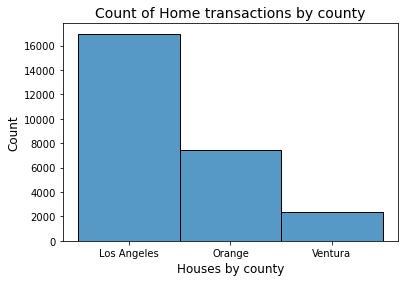

In [6]:
### 2. Which County has the highest numbers of transactions for houses?
ex.house_distro(train)

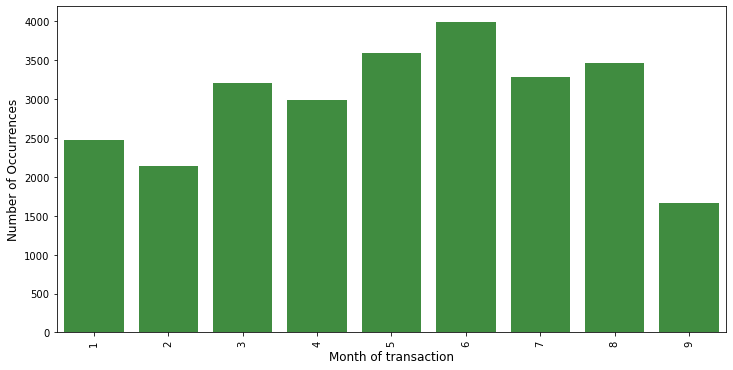

<function explore.monthly_distro(df)>

In [7]:
# 3. Wich months has the highest number of transactions?
ex.monthly_distro(train)

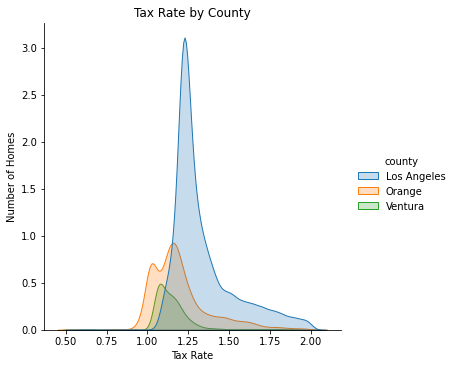

The max tax rate for all counties is 2.01 percent


In [8]:
# 4 Is the tax rate the same in each county?
ex.tax_rate_distro(train)
print(f'The max tax rate for all counties is {round(df.tax_rate.max(),2)} percent')

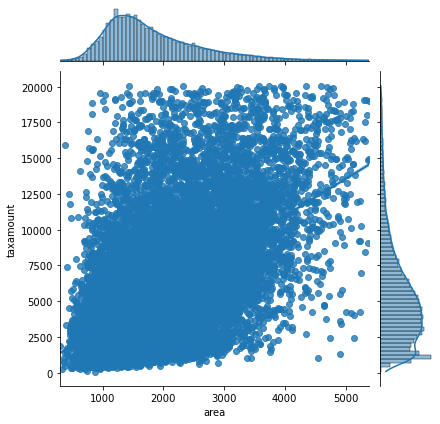

In [9]:
sns.jointplot(x= train.area, y= train.taxamount, kind = 'reg')

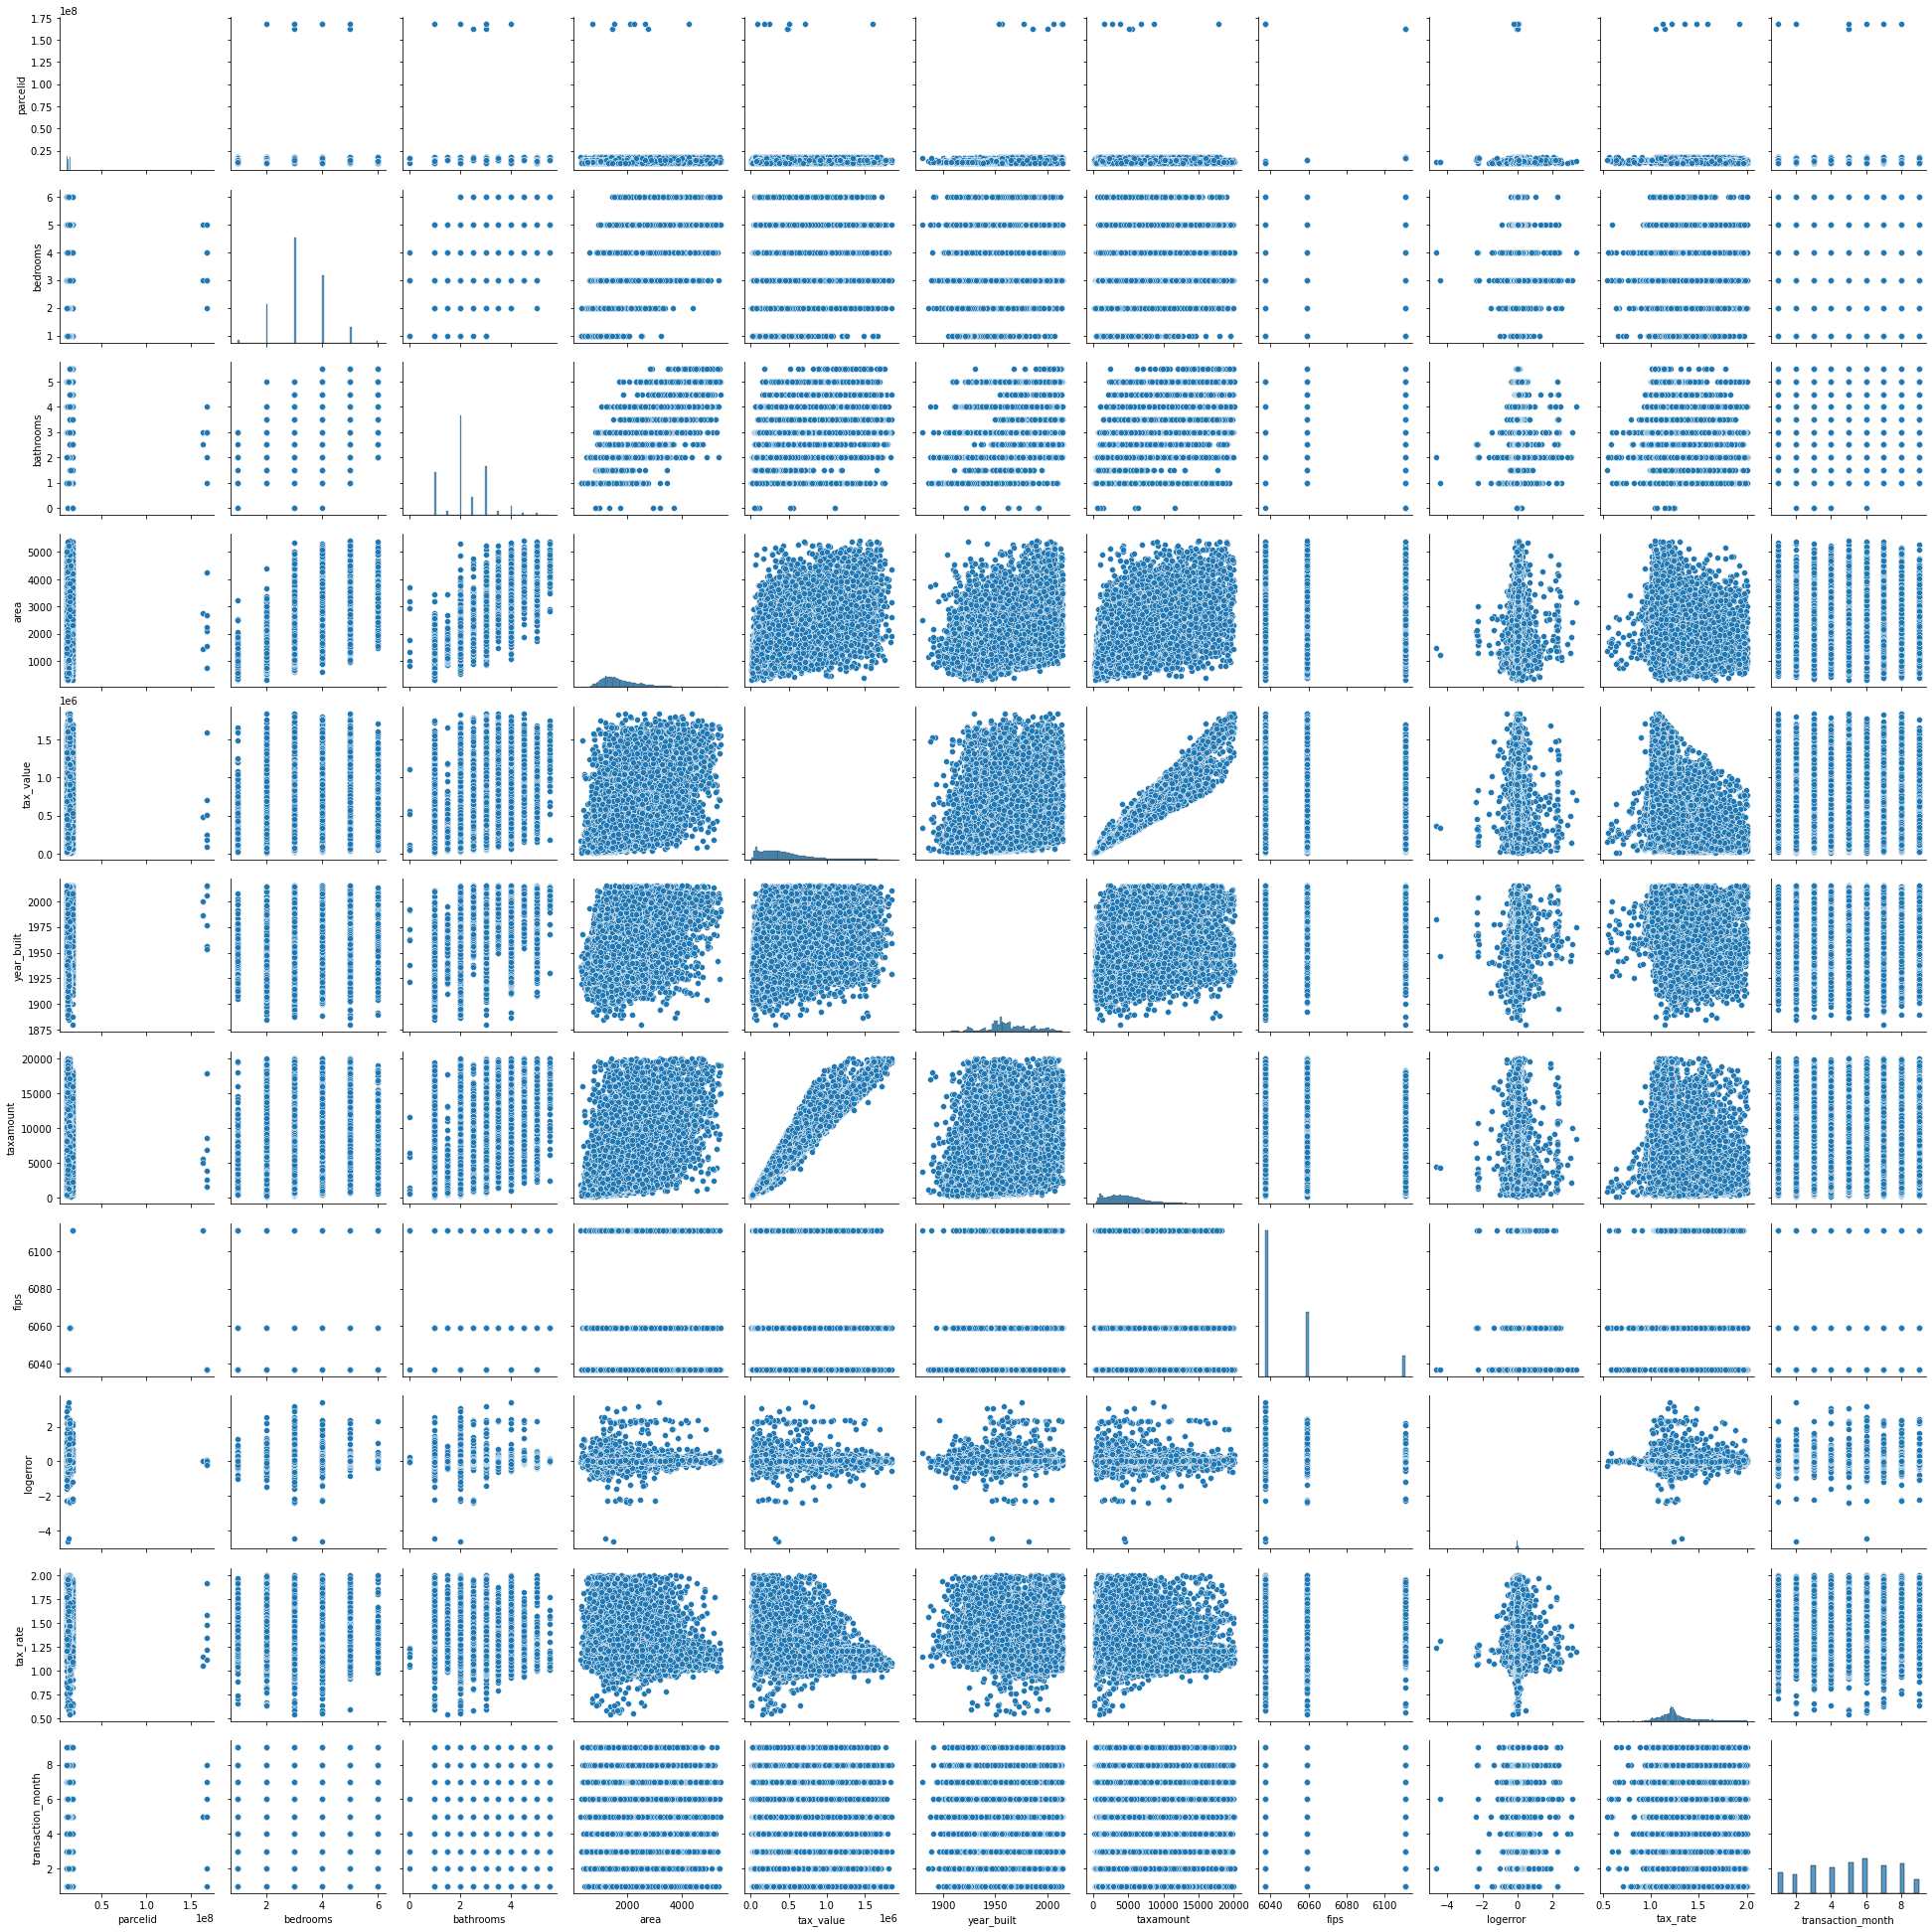

In [10]:
#pairplot
sns.pairplot(train)

In [11]:
df[df.tax_rate == df.tax_rate.max()]

,parcelid,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,logerror,transactiondate,tax_rate,county,state
11160,11233011,6.0,4.0,3757.0,327116.0,2009.0,6569.89,6037.0,-0.053909,2017-03-23,2.008428,Los Angeles,California


In [12]:
df[df.tax_rate == df.tax_rate.min()]

,parcelid,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,logerror,transactiondate,tax_rate,county,state
27356,14086690,3.0,1.5,1380.0,156101.0,1951.0,850.16,6059.0,-0.285861,2017-05-19,0.544622,Orange,California


In [13]:
df.groupby('county').count()

,parcelid,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,logerror,transactiondate,tax_rate,state
county,,,,,,,,,,,,
Los Angeles,30409,30409,30409,30409,30409,30409,30409,30409,30409,30409,30409,30409
Orange,13296,13296,13296,13296,13296,13296,13296,13296,13296,13296,13296,13296
Ventura,4187,4187,4187,4187,4187,4187,4187,4187,4187,4187,4187,4187


In [14]:
#categorical_vars = ['bedrooms', 'bathrooms','fips','parcelid']
#continuous_vars = ['area', 'tax_value']

#ex.plot_categorical_and_continuous_vars(categorical_vars, continuous_vars, train, descriptive=None)

<Figure size 720x720 with 0 Axes>

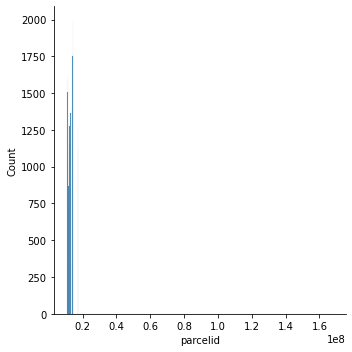

<Figure size 720x720 with 0 Axes>

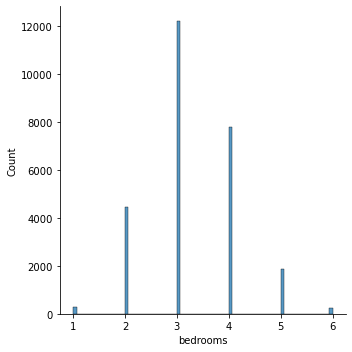

<Figure size 720x720 with 0 Axes>

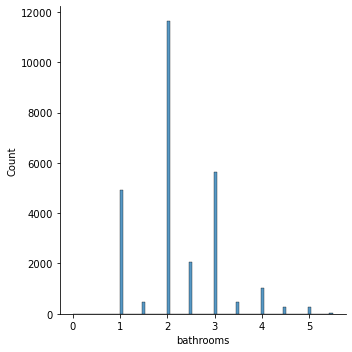

<Figure size 720x720 with 0 Axes>

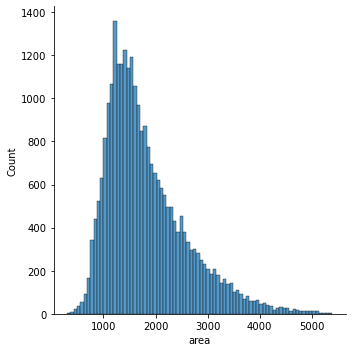

<Figure size 720x720 with 0 Axes>

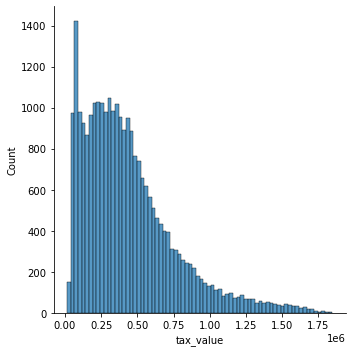

<Figure size 720x720 with 0 Axes>

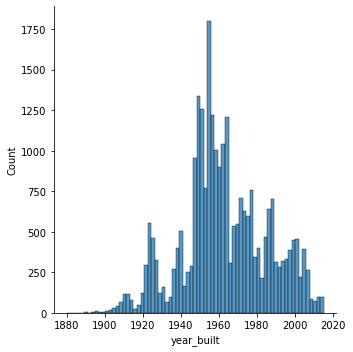

<Figure size 720x720 with 0 Axes>

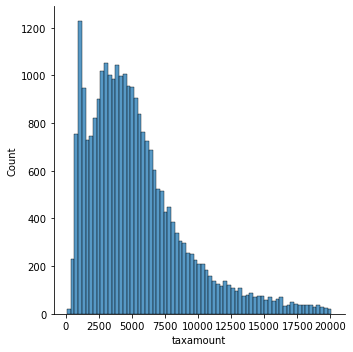

<Figure size 720x720 with 0 Axes>

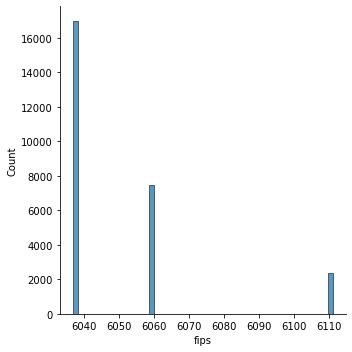

<Figure size 720x720 with 0 Axes>

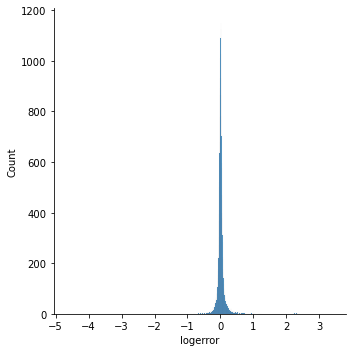

<Figure size 720x720 with 0 Axes>

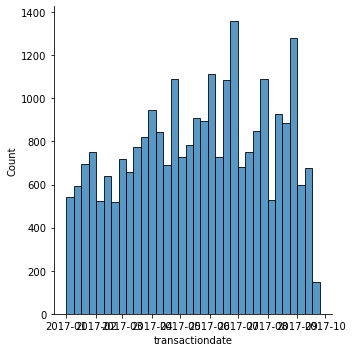

<Figure size 720x720 with 0 Axes>

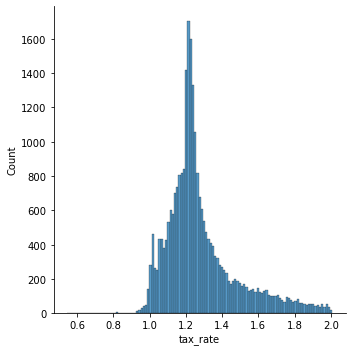

<Figure size 720x720 with 0 Axes>

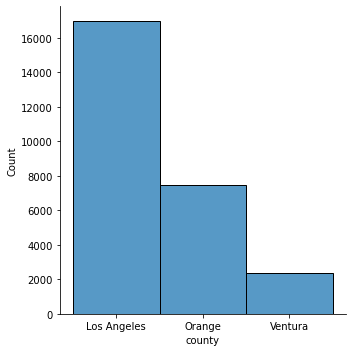

<Figure size 720x720 with 0 Axes>

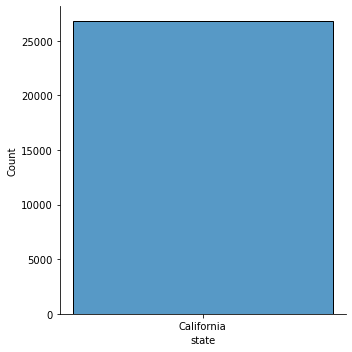

<Figure size 720x720 with 0 Axes>

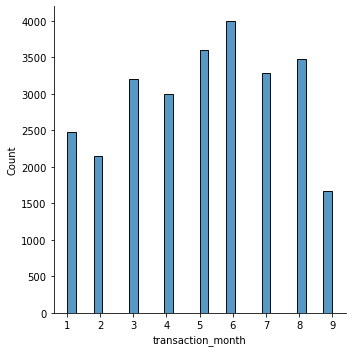

In [15]:
#lets use dis plot
for i in train.columns:
    plt.figure(figsize=(10,10))
    sns.displot(train[i])
    plt.show

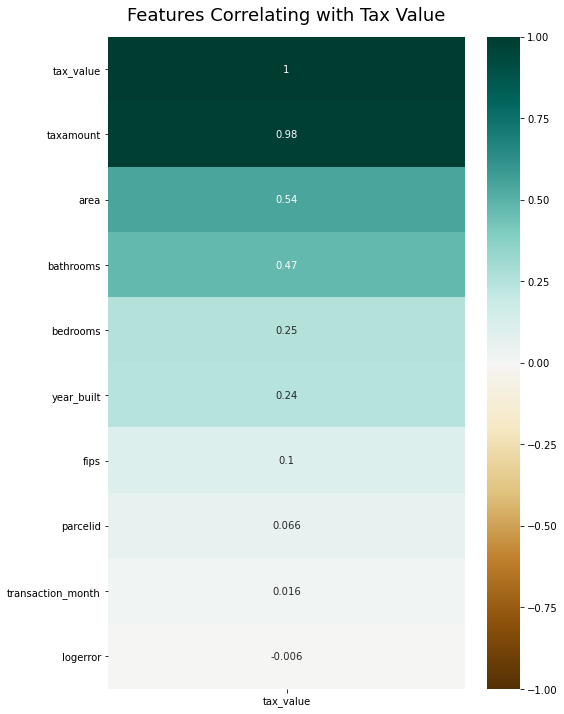

In [16]:
#Make a heatmap that shows correlation of tax value and other continous variables
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.drop(columns=['tax_rate']).corr()[['tax_value']].sort_values(by='tax_value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Tax Value', fontdict={'fontsize':18}, pad=16);

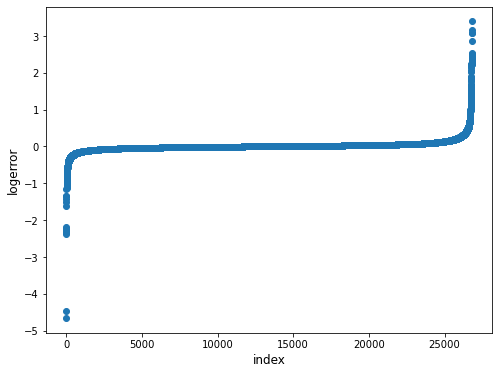

In [41]:
#ploting logerror
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

## Hypotheses 1
- H0 : There is no correlation between the area and the tax value
- H1 : Area and tax value are correlated

## Hypotheses 2 
- H0: The number of bedrooms per home is the same in all counties
- H1 : There is a difference in the number of bedrooms per home and the county location

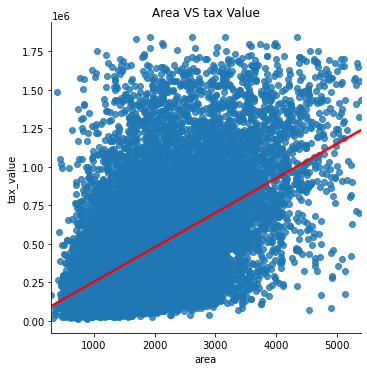

0.5417487780008441 and the p value is 0.0 We reject he null hypothesis


In [17]:
# lets test 1
x = train.area
y= train.tax_value

corr, p = stats.pearsonr(x,y)

sns.lmplot(x= 'area',y= 'tax_value', data=train, line_kws={'color':'red'})
plt.title('Area VS tax Value')
plt.show()

print(f'{corr} and the p value is {p} We reject he null hypothesis')

In [18]:
# lets test 2
observed = pd.crosstab(train.bedrooms, train.county)

chi2, p, degf, expected = stats.chi2_contingency(observed)

chi2, p
print(observed)
print(f'{chi2} and the p value is {p} We reject he null hypothesis')

county    Los Angeles  Orange  Ventura
bedrooms                              
1.0               237      59        6
2.0              3456     787      190
3.0              7998    3210      987
4.0              4176    2659      955
5.0               972     662      227
6.0               134      83       21
912.7807264021089 and the p value is 1.1301418531680415e-189 We reject he null hypothesis


## Key takeaway
- La county has the highest number of homes, the maximum tax rate and transactions 
- Orange county has the second most homes
- Ventura county has the least homes and transactions 
- Tax amount, number of bedrooms, bathrooms and area (square footage) are highly correlated with tax value
- The most transactions accured between the month of may and August
- There are some outliers in the logerror

In [19]:
# Lets scale our data 
train, validate, test = ex.add_scaled_columns(
    train,
    validate,
    test,
    scaler=sklearn.preprocessing.MinMaxScaler(),
    columns_to_scale=['area', 'bedrooms', 'bathrooms','year_built'],
)


## Modeling
- OLS
- LassoLars setting Alpha to 1
- 2 degree Polynomial regression 

In [20]:
#Modeling
train.head()

,parcelid,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,logerror,transactiondate,tax_rate,county,state,transaction_month,area_scaled,bedrooms_scaled,bathrooms_scaled,year_built_scaled
4095,11002499,2.0,1.0,1215.0,342804.0,1949.0,4137.46,6037.0,-0.009638,2017-02-10,1.206946,Los Angeles,California,2,0.179623,0.2,0.181818,0.511111
19365,12067634,2.0,1.0,1422.0,636366.0,1930.0,6925.50,6037.0,-0.138843,2017-04-21,1.088289,Los Angeles,California,4,0.220259,0.2,0.181818,0.370370
23955,13939270,3.0,3.0,2383.0,277958.0,1954.0,3254.04,6059.0,0.014894,2017-05-12,1.170695,Orange,California,5,0.408912,0.4,0.545455,0.548148
16451,14231027,3.0,2.0,1375.0,60427.0,1959.0,897.88,6059.0,-0.071161,2017-04-13,1.485892,Orange,California,4,0.211033,0.4,0.363636,0.585185
5934,11209375,4.0,3.0,1929.0,159152.0,1989.0,2838.19,6037.0,0.001931,2017-01-30,1.783320,Los Angeles,California,1,0.319788,0.6,0.545455,0.807407


In [21]:
#train.num_of_rooms.value_counts()

In [22]:
#modeling
train.drop(columns=['taxamount', 'tax_rate'], inplace=True)
validate.drop(columns=['taxamount', 'tax_rate'], inplace=True)
test.drop(columns=['taxamount', 'tax_rate'], inplace=True)

In [23]:
# Lets choose our features.
X_train = train[['area_scaled','year_built_scaled' ]]
X_validate = validate[['area_scaled','year_built_scaled']]
X_test = test[['area_scaled','year_built_scaled']]
y_train = pd.DataFrame(train['tax_value'])
y_validate = pd.DataFrame(validate['tax_value'])
y_test = pd.DataFrame(test['tax_value'])

In [24]:
#turn the y_train and y_validate into dataframes
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# We need to determine whiich is better for a baseline model. Median or Mode. 
#tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate))
print('----------------------------------')

#RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate))
print('----------------------------------')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  319220 
Validate/Out-of-Sample:  323169
----------------------------------
RMSE using Median
Train/In-Sample:  326315 
Validate/Out-of-Sample:  330863
----------------------------------


 BASELINE
----------------------------------

RMSE using Mean
Train/In-Sample:  319220 
Validate/Out-of-Sample:  323169
----------------------------------

RMSE using Median
Train/In-Sample:  326315 
Validate/Out-of-Sample:  330863
----------------------------------
Moving foward our baseline to beat is mean. Model must get a RMSE of $319220

In [25]:
metric_df = pd.DataFrame()
metric_df = ex.make_metric_df(y_train.tax_value,
                           y_train.tax_value_pred_mean,
                           'mean_baseline',
                          metric_df)

In [26]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,319220,0.0


In [27]:
# First model will be a linear regresion model
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train,y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression:\nTraining/In-Sample: ",round(rmse_train), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate))

print(f'Our Model has a rmse score that is $ {51000} more accurate than baseline')

RMSE for OLS using LinearRegression:
Training/In-Sample:  268141 
Validation/Out-of-Sample:  271833
Our Model has a rmse score that is $ 51000 more accurate than baseline


In [28]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': round(rmse_validate),
    'r^2_validate': round(explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm),3)}, ignore_index=True)


In [29]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,319220,0.000
1,OLS Regressor,271833,0.292


In [30]:
# create the model object
larso = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
larso.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = larso.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = larso.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train) , 
      "\nValidation/Out-of-Sample: ", round(rmse_validate) )
#Lasso-Lars still beats baseline about the same as the OLS

RMSE for Lasso + Lars
Training/In-Sample:  268142 
Validation/Out-of-Sample:  271832


In [31]:
metric_df = metric_df.append({
    'model': 'Lasso Lars aplha:1', 
    'RMSE_validate': round(rmse_validate),
    'r^2_validate': round(explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lars),3)}, ignore_index=True)


In [32]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,319220,0.000
1,OLS Regressor,271833,0.292
2,Lasso Lars aplha:1,271832,0.292


In [33]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 =  pf.transform(X_test)

In [34]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)** (1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", round(rmse_train), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate))

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  266662 
Validation/Out-of-Sample:  269810


In [35]:
metric_df = metric_df.append({
    'model': '2nd Degree Polynomial Regression', 
    'RMSE_validate': round(rmse_validate),
    'r^2_validate': round(explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm2),3)}, ignore_index=True)

In [36]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,319220,0.000
1,OLS Regressor,271833,0.292
2,Lasso Lars aplha:1,271832,0.292
3,2nd Degree Polynomial Regression,269810,0.303


In [37]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['tax_value_pred_lm2'] = lm2.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm2) ** (1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", round(rmse_test))
print(f'r^2_validate: {round(explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm2),2)}')

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  264859
r^2_validate: 0.3


[Text(0, 0.5, 'residual'), Text(0.5, 0, 'Tax Value')]

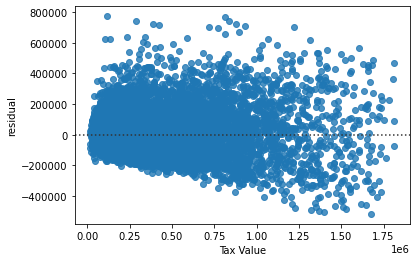

In [38]:
ax=sns.residplot(x = "tax_value",
              y = "tax_value_pred_lm2",
              data = y_test)
ax.set( ylabel = "residual", xlabel = "Tax Value")

In [39]:
y_test

,tax_value,tax_value_pred_lm2
42852,911481.0,818753.918848
10558,199877.0,330794.274604
41725,574000.0,379506.542679
7086,1229000.0,949828.987119
31270,353677.0,295813.687082
...,...,...
16424,90463.0,305407.339494
33773,1166082.0,890887.664101
1088,429718.0,344026.001675
37376,477780.0,529614.051578


## Conclusion
- 
- Best performing model was 2nd degree polynomial
- Test Finished with r2 score of .3 and RMSE2 of 264,859 which was 54,361 more acurate than basline
- I believe there are a lot to unpack from this this dataset, and this model Definitely a steeping stone to handle this this dataset, an can be finetune with time. 
- given more time i would work on engineering better features for better perfopmance